In [1]:
from collections import defaultdict
from copy import copy
from matplotlib import pyplot as plt
from matplotlib import patches
from multiprocessing import Pool
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [4]:
def obtain_xvg(args):
    rep, force = args
    xvg_lines = []
    force_str = str(force // 4 if force % 4 == 0 else force / 4)
    
    skip_counter = 0
    with open("/data/analytics/catch_bonds/1sq0_180911/dists/{}_{}.xvg".format(rep, force_str), "r") as f:
        for line in f:
            if skip_counter < 24:
                skip_counter += 1
                continue

            xvg_lines.append([float(s) for s in line.split()])
            
    xvg_arr = np.array(xvg_lines)[:, 1:]
    np.savez_compressed("/data/analytics/catch_bonds/1sq0_180911/dists_npz/{}_{}.npz"
                        .format(rep, force_str), xvg_arr)

def get_pair(num, first_chain_len):
    f = num % first_chain_len
    s = num // first_chain_len
    return (f + 1, s + 1)

def get_index(f, s, first_chain_len):
    return (s - 1) * first_chain_len + (f - 1)

In [5]:
FIRST_CHAIN = 198
SECOND_CHAIN = 265
MAX_DIST = 0.3
MIN_OCCUPANCY = 0.1

PAIRS = FIRST_CHAIN * SECOND_CHAIN
FORCES = 21
REPS = 10
FRAMES = 1000

dists_arrs = []

In [7]:
args = [(rep, force) for rep in range(0, REPS) for force in range(FORCES)]
with Pool(50) as p:
    for i, r in tqdm(enumerate(p.imap(obtain_xvg, args)), total=len(args)):
        pass

In [9]:
whole_arr = np.zeros((REPS, FORCES, FRAMES, PAIRS), dtype=np.float16)

for rep in tqdm(range(REPS)):
    for force in range(FORCES):
        force_str = str(force // 4 if force % 4 == 0 else force / 4)
        npz_file = np.load("/data/analytics/catch_bonds/1sq0_180911/dists_npz/{}_{}.npz".format(rep, force_str))
        whole_arr[rep - 1, force, :, :] = npz_file["arr_0"]

In [10]:
np.savez_compressed("/data/analytics/catch_bonds/1sq0_180911/dists_npz/whole.npz", whole_arr)

In [4]:
whole_arr = np.load("/data/analytics/catch_bonds/1sq0_180911/dists_npz/whole.npz")["arr_0"]

drop R3_35, R4_35, R8_28, R10_42

In [11]:
candidates = set()

for f in tqdm(range(FORCES)):
    for i in range(whole_arr.shape[3]):
        p_10 = np.percentile(whole_arr[:, f, :, i].flatten(), 10)
        if p_10 < .5:
            candidates.add(i)

In [13]:
z_f_percentiles = [[np.percentile(whole_arr[:, 0, :, c], 5 * p) for p in range(1, 20)] for c in candidates]
diffs_dict = dict()

for c_i, c in enumerate(candidates):
    for f in range(1, whole_arr.shape[1]):
        diffs_dict[(c, f)] = 0
        for p in range(1, 20):
            cur_rep = list(range(10)) 
            cur_p = np.percentile(whole_arr[cur_rep, f, :, c], 5 * p)
            cur_diff = cur_p - z_f_percentiles[c_i][p - 1]
            diffs_dict[(c, f)] += cur_diff

In [26]:
cand_tuples = sorted([(get_pair(k[0], FIRST_CHAIN), k[1], v) for k, v in diffs_dict.items()])
cand_tuples = [(c[0][0] + 1268, c[0][1], c[1] * 17.5, c[2]) for c in cand_tuples if c[2]]
cand_df = pd.DataFrame(cand_tuples)
cand_df.columns = ["FirstChain", "SecondChain", "Force", "DiffSum"]
[g[1][g[1].Force <= 200] for g in cand_df.groupby(["FirstChain", "SecondChain"]) if any(g[1].DiffSum < -5)]

[    FirstChain  SecondChain  Force    DiffSum
 0         1275            9   17.5   2.462793
 1         1275            9   35.0  -8.617725
 2         1275            9   52.5   0.789307
 3         1275            9   70.0   4.212256
 4         1275            9   87.5   4.167749
 5         1275            9  105.0   2.431641
 6         1275            9  122.5  13.798242
 7         1275            9  140.0  17.401025
 8         1275            9  157.5  22.113379
 9         1275            9  175.0  28.339307
 10        1275            9  192.5  28.637549,
     FirstChain  SecondChain  Force    DiffSum
 20        1275           12   17.5   0.706152
 21        1275           12   35.0  -8.530176
 22        1275           12   52.5  -0.964063
 23        1275           12   70.0   3.353223
 24        1275           12   87.5   4.268652
 25        1275           12  105.0   2.394482
 26        1275           12  122.5  13.795215
 27        1275           12  140.0  17.281836
 28        1

In [ ]:
display_params = [
    (t[0], np.arange(9), np.array([0, 1, 2, 3, 4, 5, 6, 8, 9]), np.arange(9), t[1]) for t in cand_tuples
]

fig = plt.figure(figsize=(18, 3 * len(display_params)))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")

for param_i, param in enumerate(display_params):
    f, s = param[0]
    pair_str = "{}A — {}B".format(f, s)
    r1, r2, r3 = param[1], param[2], param[3]
    force = param[4]
    cur_pair = get_index(f, s, FIRST_CHAIN)
    
    XMAX = 5
    YMAX = 4

    ylims = []
    axes = []
    
    ax = fig.add_subplot(len(display_params) // 2, 2, 1 + param_i * 1)
    cur_line = sns.kdeplot(whole_arr[r1, 0, :, cur_pair].flatten(), bw=.05, label="0 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_xlabel("Distance", fontdict={"size": 14})
    ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 14})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r2, force, :, cur_pair].flatten(), bw=.05, label="{} pN".format(force * 7), linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_title("{}".format(pair_str), fontdict={"size": 18})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r3, 9, :, cur_pair].flatten(), bw=.05, label="63 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    axes.append(ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=20)
    
    for ax in axes:
        ax.set_xlim(0, 5)
        ax.set_ylim(0, np.max([l[1] for l in ylims]))
        
        [t.set_fontsize(16) for t in ax.get_xticklabels()]
        ax.set_xlabel("Distance, Å", fontdict={"size": 16})
        [t.set_fontsize(16) for t in ax.get_yticklabels()]
        ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 20})
        
plt.tight_layout()

In [ ]:
zero_force_flatten = whole_arr[:, 0, :, :].reshape(-1, whole_arr.shape[3])
zero_force_medians = np.median(zero_force_flatten, axis=0)
zero_force_contacts = zero_force_medians < 1

force_pairs_dict = dict()
results = []

for force in tqdm(range(1, FORCES), total=FORCES - 1):
    m_force_flatten = whole_arr[:, force, :, :].reshape(-1, whole_arr.shape[3])
    m_force_medians = np.median(m_force_flatten, axis=0)
    for i, (f, z) in enumerate(zip(m_force_medians.tolist(), zero_force_medians.tolist())):
        if f < .9 * z and f < 1:
            results.append((f, z, force, get_pair(i, FIRST_CHAIN)))

In [ ]:
median_tuples = [t for t in sorted(results, key=lambda t: t[2] / t[1]) if t[0] < .6]

In [ ]:
display_params = [
    (t[3], np.arange(9), np.array([0, 1, 2, 3, 4, 5, 6, 8, 9]), np.arange(9), t[2]) for t in median_tuples
]

fig = plt.figure(figsize=(18, 3 * len(display_params)))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")

for param_i, param in enumerate(display_params):
    f, s = param[0]
    pair_str = "{}A — {}B".format(f, s)
    r1, r2, r3 = param[1], param[2], param[3]
    force = param[4]
    cur_pair = get_index(f, s, FIRST_CHAIN)
    
    XMAX = 5
    YMAX = 4

    ylims = []
    axes = []
    
    ax = fig.add_subplot(len(display_params) // 2, 2, 1 + param_i * 1)
    cur_line = sns.kdeplot(whole_arr[r1, 0, :, cur_pair].flatten(), bw=.05, label="0 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_xlabel("Distance", fontdict={"size": 14})
    ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 14})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r2, force, :, cur_pair].flatten(), bw=.05, label="{} pN".format(force * 7), linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_title("{}".format(pair_str), fontdict={"size": 18})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r3, 9, :, cur_pair].flatten(), bw=.05, label="63 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    axes.append(ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=20)
    
    for ax in axes:
        ax.set_xlim(0, 5)
        ax.set_ylim(0, np.max([l[1] for l in ylims]))
        
        [t.set_fontsize(16) for t in ax.get_xticklabels()]
        ax.set_xlabel("Distance, Å", fontdict={"size": 16})
        [t.set_fontsize(16) for t in ax.get_yticklabels()]
        ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 20})
        
plt.tight_layout()

In [75]:
PREFIX = "/data/analytics/catch_bonds/1sq0_180911/dists_cog"
mean_dist_dict = defaultdict(list)
std_dist_dict = defaultdict(list)

for rep in range(10):
    for force in np.arange(0, 5.1, .25):
        force_str = str(int(force)) if force == int(force) else str(force)
        dists_df = pd.read_csv("{}/{}_{}.xvg".format(PREFIX, rep, force_str), skiprows=24, header=None, sep="    ")
        dists_df.columns = ["frame", "max_dist"]
        
        mean_dist_dict[force].append(dists_df.max_dist.mean())
        std_dist_dict[force].append(dists_df.max_dist.std())

/home/analytics/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Text(0,0.5,'Mean maximum distance')

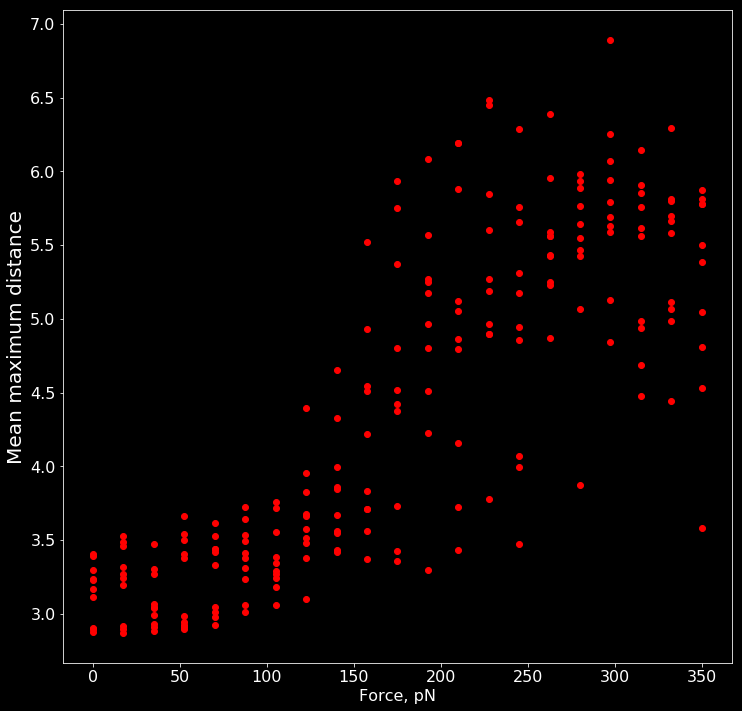

In [76]:
fig = plt.figure(figsize=(12, 12))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")
ax = fig.add_subplot(1, 1, 1)

for k, v in mean_dist_dict.items():
    ax.plot([k * 70] * len(v), v, "ro")
    
[t.set_fontsize(16) for t in ax.get_xticklabels()]
ax.set_xlabel("Force, pN", fontdict={"size": 16})
[t.set_fontsize(16) for t in ax.get_yticklabels()]
ax.set_ylabel("Mean maximum distance", fontdict={"size": 20})

In [48]:
PREFIX = "/data/analytics/catch_bonds/1sq0_180911/dists_min_chains"
mean_dist_dict = defaultdict(list)
std_dist_dict = defaultdict(list)

for rep in range(10):
    for force in np.arange(0, 5.1, .25):
        force_str = str(int(force)) if force == int(force) else str(force)
        dists_df = pd.read_csv("{}/{}_{}.xvg".format(PREFIX, rep, force_str), skiprows=24, header=None, sep="\s+")
        dists_df.columns = ["frame", "max_dist"]
        
        mean_dist_dict[force].append(dists_df.max_dist.mean())
        std_dist_dict[force].append(dists_df.max_dist.std())

Text(0,0.5,'Mean minimum distance')

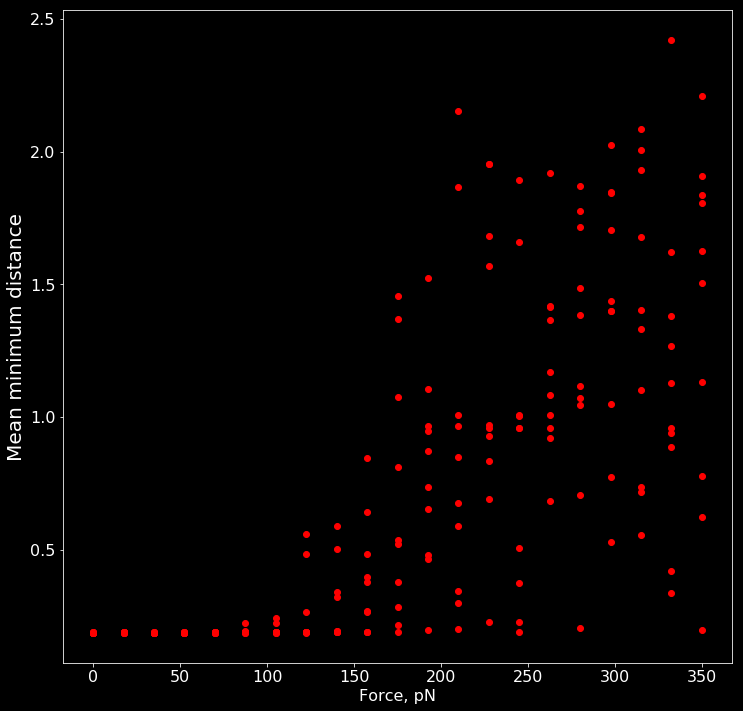

In [59]:
fig = plt.figure(figsize=(12, 12))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")
ax = fig.add_subplot(1, 1, 1)

for k, v in sorted(mean_dist_dict.items()):
    ax.plot([k * 70] * len(v), v, "ro")
    
[t.set_fontsize(16) for t in ax.get_xticklabels()]
ax.set_xlabel("Force, pN", fontdict={"size": 16})
[t.set_fontsize(16) for t in ax.get_yticklabels()]
ax.set_ylabel("Mean minimum distance", fontdict={"size": 20})

In [41]:
PREFIX = "/data/analytics/catch_bonds/1sq0_180911/dists_min_chains"
lifetime_dict = defaultdict(list)

for rep in range(10):
    for force in np.arange(0, 5.1, .25):
        force_str = str(int(force)) if force == int(force) else str(force)
        dists_df = pd.read_csv("{}/{}_{}.xvg".format(PREFIX, rep, force_str), skiprows=24, header=None, sep="\s+")
        dists_df.columns = ["frame", "max_dist"]
        
        try:
            lifetime_dict[force].append((np.where(dists_df.max_dist > 1))[0][0])
        except IndexError:
            lifetime_dict[force].append(1000)

Text(0,0.5,'Mean lifetime, frames')

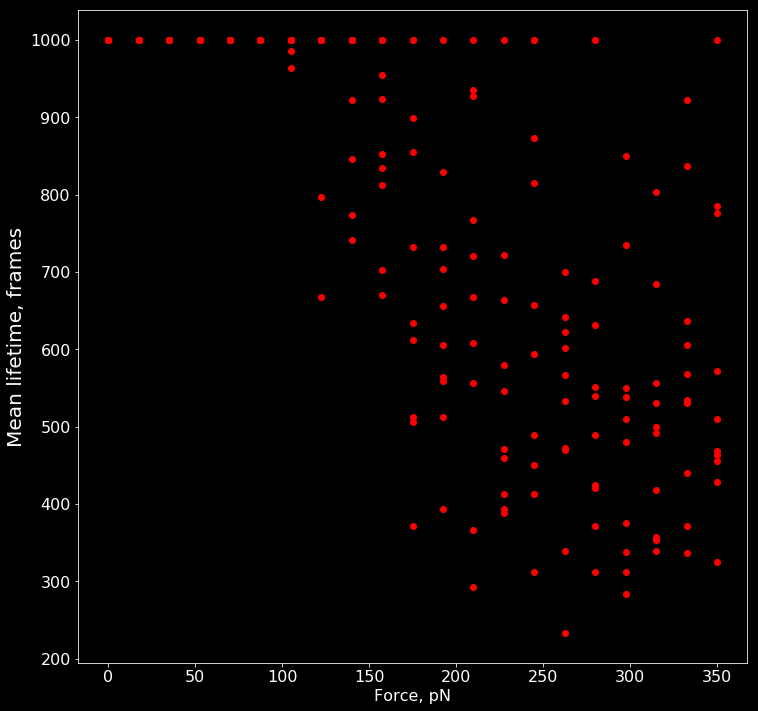

In [42]:
fig = plt.figure(figsize=(12, 12))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")
ax = fig.add_subplot(1, 1, 1)

for k, v in lifetime_dict.items():
    ax.plot([k * 70] * len(v), v, "ro")
    
[t.set_fontsize(16) for t in ax.get_xticklabels()]
ax.set_xlabel("Force, pN", fontdict={"size": 16})
[t.set_fontsize(16) for t in ax.get_yticklabels()]
ax.set_ylabel("Mean lifetime, frames", fontdict={"size": 20})